# Setup

### Load contents of setup.py
Import modules, prepare signals

In [1]:
# %load setup.py
import cv2
import h5py  # hdf5 reader/writer
import hyperspy.api as hs  # hyperspy
import image_processing as ipm
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
import SimpleITK as sitk
import skimage

from scipy import ndimage as ndi
from scipy import signal
from scipy.ndimage.filters import gaussian_filter

# Load signal data from files

fin_1 = h5py.File("data/89109_16_Fe_mantis_norm.hdf5")
data_1 = fin_1["/exchange/data"]
signal_1 = hs.signals.Signal2D(data_1)
signal_1 = signal_1.transpose(signal_axes=(0,2))

fin_2 = h5py.File("data/mantis_55510_55660.hdf5")
data_2 = fin_2["/exchange/data"]
signal_2 = hs.signals.Signal2D(data_2)
signal_2 = signal_2.transpose(signal_axes=(0,2))

fin_3 = h5py.File("data/mantis_raw_55499_55509.hdf5")
data_3 = fin_3["/exchange/data"]
signal_3 = hs.signals.Signal2D(data_3)
signal_3 = signal_3.transpose(signal_axes=(0,2))

signal_4 = hs.load("data/0005-RotSTEM90 ADF1.dm3")
signal_5 = hs.load("data/20_Aligned 20-Stack-5MxHAADF STACK(20).dm3")

# Generate a very simple synthetic signal for demonstration purposes

height = 38
width = 46

vfield_1 = np.array([np.ones((height, width)) * -2, np.ones((height, width)) * +1])
vfield_2 = np.array([np.ones((height, width)) * -2.7, np.ones((height, width)) * +1.2])

arr_A = ipm.make_capital_A((height, width))
signal_A = hs.signals.Signal2D(np.array([arr_A, ipm.apply_displacement_field_sitk(vfield_1, arr_A), ipm.apply_displacement_field_sitk(vfield_2, arr_A)]))

arr_i = np.arange(height).reshape(height, 1)
arr_j = np.arange(width).reshape(1, width)
# i_plus, i_minus: vertical coordinates of +ve and -ve 'charges'
i_plus = height * 0.75
i_minus = height * 0.25
# j_plus, j_minus: horizontal coordinates of +ve and -ve 'charges'
j_plus = width * 0.25
j_minus = width * 0.75
# dsquared_plus[i][j] = distance squared between +ve 'charge' and pixel i,j
# dsquared_minus[i][j] = distance squared between -ve 'charge' and pixel i,j
dsquared_plus = (arr_i - i_plus)**2 + (arr_j - j_plus)**2
dsquared_minus = (arr_i - i_minus)**2 + (arr_j - j_minus)**2
scale = 2
power = 2

# vfield_3 represents a shift similar to the force experienced by a small test charge under the influence of two fixed point charges: one positive, one negative. Unlike vfield_1 and vfield_2, it is non-uniform.
# vfield_3[i][j] = scale * sum[r_hat * 'charge' * (1/distance from 'charge')^power]
# r_hat = (i - i_plus)/(dsquared^0.5)
# therefore vfield_3[i][j] = scale * sum[(i - i_plus) * 'charge' * (1/distance from 'charge')^(power+1)]
factor_plus = scale * (dsquared_plus**(-0.5*(1+power)))
factor_minus = scale * (dsquared_minus**(-0.5*(1+power)))
vfield_3_i = (arr_i - i_plus) * factor_plus + (i_minus - arr_i) * factor_minus
vfield_3_j = (arr_j - j_plus) * factor_plus + (j_minus - arr_j) * factor_minus
vfield_3 = np.array([vfield_3_i, vfield_3_j])

# Generate another synthetic signal for demonstration purposes

num_keyframes = 3
num_between_keyframes = 6
num_frames = (num_between_keyframes + 1) * num_keyframes
key_indices = np.arange(num_keyframes + 1) * (num_between_keyframes+1) # 0, 3, 6, 9
key_scale_x = np.random.rand(num_keyframes + 1) * 0.4 + 0.8
key_scale_y = np.random.rand(num_keyframes + 1) * 0.4 + 0.8
key_shear = np.random.rand(num_keyframes + 1) * (2*math.pi/12) - math.pi/12
key_rotation = np.random.rand(num_keyframes + 1) * (2*math.pi/6) - math.pi/6
key_offset_x = np.random.rand(num_keyframes + 1) * (0.4 * height) - (0.2 * height)
key_offset_y = np.random.rand(num_keyframes + 1) * (0.4 * width) - (0.2 * width)
key_scale_x[-1] = key_scale_x[0]
key_scale_y[-1] = key_scale_y[0]
key_shear[-1] = key_shear[0]
key_rotation[-1] = key_rotation[0]
key_offset_x[-1] = key_offset_x[0]
key_offset_y[-1] = key_offset_y[0]
spline_scale_x = scipy.interpolate.InterpolatedUnivariateSpline(key_indices, key_scale_x)
spline_scale_y = scipy.interpolate.InterpolatedUnivariateSpline(key_indices, key_scale_y)
spline_shear = scipy.interpolate.InterpolatedUnivariateSpline(key_indices, key_shear)
spline_rotation = scipy.interpolate.InterpolatedUnivariateSpline(key_indices, key_rotation)
spline_offset_x = scipy.interpolate.InterpolatedUnivariateSpline(key_indices, key_offset_x)
spline_offset_y = scipy.interpolate.InterpolatedUnivariateSpline(key_indices, key_offset_y)
all_scale_x = spline_scale_x(np.arange(0, num_frames))
all_scale_y = spline_scale_y(np.arange(0, num_frames))
all_shear= spline_shear(np.arange(0, num_frames))
all_rotation = spline_rotation(np.arange(0, num_frames))
all_offset_x = spline_offset_x(np.arange(0, num_frames))
all_offset_y = spline_offset_y(np.arange(0, num_frames))
signal_A_2 = hs.signals.Signal2D(np.empty((num_frames, arr_A.shape[0], arr_A.shape[1])))
for t in range(num_frames):
    signal_A_2.data[t] = ipm.transform_using_values(arr_A, [all_scale_x[t], all_scale_y[t], all_shear[t], all_rotation[t], all_offset_x[t], all_offset_y[t]])


### Display the unmodified datasets
Use `%matplotlib qt` to set up IPython for interactive plotting with matplotlib.

In [5]:
%matplotlib qt
signal_1.plot()

In [10]:
%matplotlib qt
signal_2.plot()

In [10]:
%matplotlib qt
signal_3.plot()

In [4]:
%matplotlib qt
signal_4.plot()

In [5]:
%matplotlib qt
signal_5.plot()

In [10]:
%matplotlib qt
signal_A.plot()

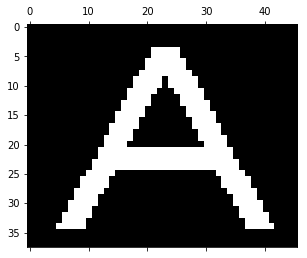

In [27]:
plt.matshow(arr_A)

# Image stack analysis

## Comparing each pixel with the image as a whole

#### `ipm.get_signal_average_difference( signal_in: hs.signals.Signal2D )`

Average intensity difference across whole image from current pixel.

A'(i, j) = mean value of |A - A(i, j)|

In [7]:
avg_diff_1 = ipm.get_signal_average_difference(signal_1)

In [5]:
%matplotlib qt
hs.plot.plot_signals([signal_1, avg_diff_1])

#### `ipm.get_signal_average_rank_difference( signal_in: hs.signals.Signal2D, weighted=False )`

Average intensity rank difference across whole image from current pixel.

A'(i, j) = mean value of |R - R(i, j)|, where A(i, j) is the R(i, j)<sup>th</sup>-brightest pixel

If `weighted` is True, the differences are each multiplied by the mean value of the absolute difference between the current image and the intensity of the current pixel.

In [6]:
avg_rank_diff_1 = ipm.get_signal_average_rank_difference(signal_1)
avg_rank_diff_1_weighted = ipm.get_signal_average_rank_difference(signal_1, weighted=True)

In [7]:
%matplotlib qt
hs.plot.plot_signals([signal_1, avg_diff_1, avg_rank_diff_1, avg_rank_diff_1_weighted])

## Exploring a signal's temporal characteristics

#### `ipm.get_deltas( signal_in: hs.signals.Signal2D, absolute=False, normalised=True )`

Difference between next and current intensity of each pixel.

Returns a signal of type `hs.signals.Signal2D`

In [6]:
deltas_1 = ipm.get_deltas(signal_1)
# deltas_1.data[t] = signal_1.data[t+1] - signal_1.data[t]

# Append an all-zero image to deltas_1 so that deltas_1 has the same number of images as signal_1
deltas_1 = hs.signals.Signal2D(np.append(deltas_1.data, [np.zeros_like(deltas_1.data[0])], axis=0))

# Display signal_1 and deltas_1
hs.plot.plot_signals([signal_1, deltas_1])

#### `ipm.split_by_mutual_information( signal_in: hs.signals.Signal2D, threshold=0.3 )`

Split a signal into a list of numpy arrays of images. Each numpy array in the list contains a subsection of the original signal. For each image in a subsection, the mutual information between that image and the first image in the subsection must be at least some value given by the `threshold` parameter.

In [4]:
list_1 = ipm.split_by_mutual_information(signal_1)
list_2 = ipm.split_by_mutual_information(signal_2)
list_3 = ipm.split_by_mutual_information(signal_3)

#### Print the number of subsections in each list

In [5]:
[len(list_1), len(list_2), len(list_3)]

[24, 10, 1]

#### Print the number of images in each subsection of each list

In [6]:
lengths = [[],[],[]]
for i in range(len(list_1)):
    lengths[0].append(list_1[i].shape[0])
for i in range(len(list_2)):
    lengths[1].append(list_2[i].shape[0])
for i in range(len(list_3)):
    lengths[2].append(list_3[i].shape[0])
lengths

[[11, 38, 25, 26, 1, 3, 2, 1, 3, 2, 1, 4, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [61, 78, 4, 1, 1, 1, 1, 1, 1, 1],
 [1]]

#### Display the images in the first subsection of `list_1`

In [7]:
%matplotlib qt
hs.signals.Signal2D(list_1[0]).plot()

#### Apply nonrigid registration to this subsection. Display both the original and registered signal.

In [8]:
out_stack = ipm.nonrigid(list_1[0], default_pixel_value = list_1[0].mean())
%matplotlib qt
hs.plot.plot_signals([hs.signals.Signal2D(list_1[0]), hs.signals.Signal2D(out_stack)])

#### `ipm.highest_mutual_information_index(signal_in: hs.signals.Signal2D, exponent=1)`

Iterates over an image stack. For each image, the sum of the mutual information between that image and each other image (raised to the power `exponent`) is calculated. The index of the image for which this value is greatest is returned.

For `exponent` values less than 1, low mutual information pairs are more heavily penalised: the index returned will correspond to an image that is moderately representative of the whole stack.
    
For `exponent` values greater than 1, high mutual information pairs are more strongly rewarded: the index returned will correspond to an image that is highly representative of some subset of the stack.

In [12]:
max_mi_1 = ipm.highest_mutual_information_index(signal_1)
max_mi_2 = ipm.highest_mutual_information_index(signal_2)
max_mi_3 = ipm.highest_mutual_information_index(signal_3)
max_mi_4 = ipm.highest_mutual_information_index(signal_4)
max_mi_5 = ipm.highest_mutual_information_index(signal_5)
max_mi_A = ipm.highest_mutual_information_index(signal_A)

#### Print the image indices returned above

In [19]:
[max_mi_1, max_mi_2, max_mi_3, max_mi_4, max_mi_5, max_mi_A]

[33, 66, 7, 18, 8, 1]

#### Display the image in `signal_1` corresponding to the index `max_mi_1`. This may be considered as the element of `signal_1` that best represents the whole image stack.

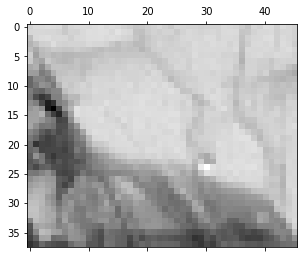

In [13]:
plt.matshow(signal_1.data[max_mi_1])

#### Display the "most representative" image in `signal_2`

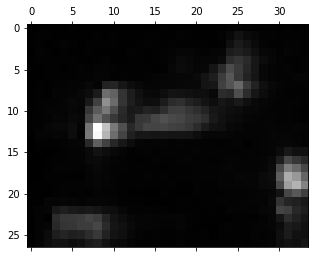

In [18]:
plt.matshow(signal_2.data[max_mi_2])

#### Display the "most representative" image in `signal_3`

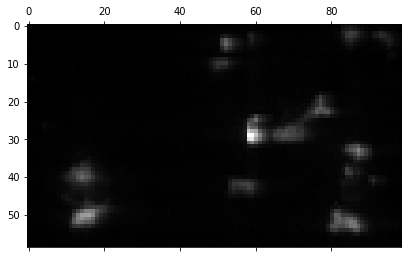

In [17]:
plt.matshow(signal_3.data[max_mi_3])

#### Display the "most representative" image in `signal_4`

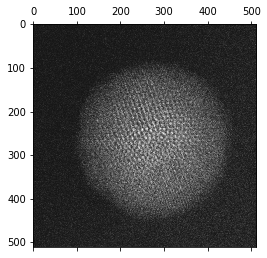

In [16]:
plt.matshow(signal_4.data[max_mi_4])

#### Display the "most representative" image in `signal_5`

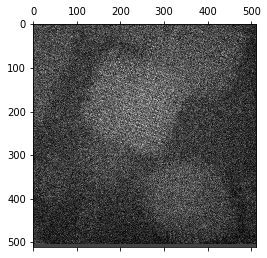

In [15]:
plt.matshow(signal_5.data[max_mi_5])

#### Display the "most representative" image in `signal_A`

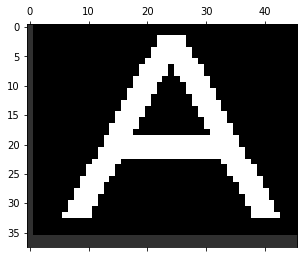

In [14]:
plt.matshow(signal_A.data[max_mi_A])

## Exploring a signal's spatial characteristics

#### `ipm.get_neighbour_similarity( arr_in: np.array, exponent=2 )`

Similarity to neighbouring pixels relative to whole image.
    
The purpose of this method is to obtain a measure of confidence in the intensity value of each pixel. High confidence values are given to pixels that are similar to their neighbours and dissimilar from the average pixel.

The optional `exponent` parameter controls the strength with which distance between pixels is penalised. If `exponent` is large (say, greater than 2), only pixels very close to the pixel under consideration may be considered 'neighbours'.

Ultimately, this or a similar method may be used in conjunction with an optical flow algorithm to determine the strength of the smoothness constraint at each point.

The current implementation of this method is quite crude, but nonetheless produces qualitatively sensible results.

In [2]:
# Run `get_neighbour_similarity` on one of the clearer images in signal_1
ns_1_94 = ipm.get_neighbour_similarity(signal_1.data[94])
nsf_1_94 = ipm.get_neighbour_similarity_faster(signal_1.data[94], print_progress=True)

# Normalise both arrays (otherwise the original appears very light and ns_1_94 appears very dark)
range_pre = signal_1.data[94].max() - signal_1.data[94].min()
signal_1_94_normalised = (signal_1.data[94] - signal_1.data[94].min()) / range_pre
range_post = ns_1_94.max() - ns_1_94.min()
ns_1_94_normalised = (ns_1_94 - ns_1_94.min()) / range_post
nsf_1_94_normalised = (nsf_1_94 - nsf_1_94.min()) / range_post

feature_length = 1, exponent = 2
(h, w) = (38, 46), (h_small, w_small) = (38, 46)
weights_all constructed
Row 1 of 38: i_small = 0
Row 2 of 38: i_small = 1
Row 3 of 38: i_small = 2
Row 4 of 38: i_small = 3
Row 5 of 38: i_small = 4
Row 6 of 38: i_small = 5
Row 7 of 38: i_small = 6
Row 8 of 38: i_small = 7
Row 9 of 38: i_small = 8
Row 10 of 38: i_small = 9
Row 11 of 38: i_small = 10
Row 12 of 38: i_small = 11
Row 13 of 38: i_small = 12
Row 14 of 38: i_small = 13
Row 15 of 38: i_small = 14
Row 16 of 38: i_small = 15
Row 17 of 38: i_small = 16
Row 18 of 38: i_small = 17
Row 19 of 38: i_small = 18
Row 20 of 38: i_small = 19
Row 21 of 38: i_small = 20
Row 22 of 38: i_small = 21
Row 23 of 38: i_small = 22
Row 24 of 38: i_small = 23
Row 25 of 38: i_small = 24
Row 26 of 38: i_small = 25
Row 27 of 38: i_small = 26
Row 28 of 38: i_small = 27
Row 29 of 38: i_small = 28
Row 30 of 38: i_small = 29
Row 31 of 38: i_small = 30
Row 32 of 38: i_small = 31
Row 33 of 38: i_small = 32
Row 34 of 38: i_small 

#### `ipm.scale_intensity_to_data( arr_in: np.array, intensity_data: np.array )`

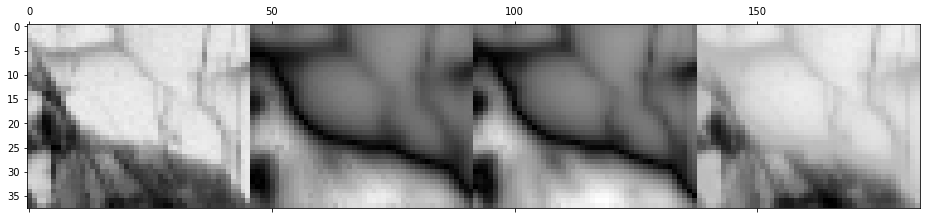

In [3]:
ns_1_94_scaled = ipm.scale_intensity_to_data(signal_1.data[94], ns_1_94_normalised)

ns_1_94_scaled_normalised = ipm.normalised_image(ns_1_94_scaled)

# Display side by side
plt.matshow(np.hstack((signal_1_94_normalised, ns_1_94_normalised, nsf_1_94_normalised, ns_1_94_scaled_normalised)))

Left to right: frame 94 of `signal_1` (i.e. 89109_16_Fe_mantis_norm.hdf5); output of `get_neighbour_similarity` on this image; output of `get_neighbour_similarity_faster` (which performs downsampling to reduce processing time) on that same image; output of `scale_intensity_to_data`, which brings the intensity of high-uncertainty pixels close to a mean value, thereby emphasising the pixels with lower uncertainty as judged by `get_neighbour_similarity`.

#### `ipm.get_signal_neighbour_similarity( signal_in: hs.signals.Signal2D, exponent=2 )`

Run `get_neighbour_similarity` on a whole image stack.

In [3]:
chosen_signal = signal_1

In [4]:
# Warning: slow, especially on high-resolution image stacks such as signal_4
ns = ipm.get_signal_neighbour_similarity_approx_v2(chosen_signal, print_progress=False)

/home/fqj69741/notebooks/image_processing.py:66: RuntimeWarning: invalid value encountered in true_divide
  return (arr_in - arr_in.min()) / (arr_in.max() - arr_in.min())


#### `ipm.scale_signal_to_data( signal_in: hs.signals.Signal2D, intensity_signal: hs.signals.Signal2D )`

In [5]:
ns_scaled = ipm.scale_signal_to_data(chosen_signal, ns)

In [6]:
%matplotlib qt
hs.plot.plot_signals([chosen_signal, ns, ns_scaled])

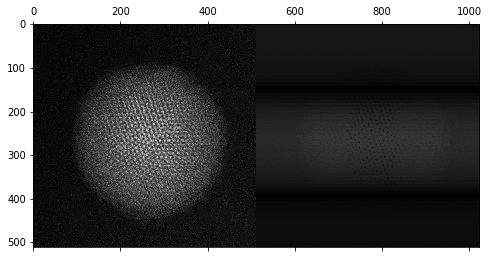

In [4]:
plt.matshow(np.hstack((ipm.normalised_image(signal_4.data[0]), ipm.get_neighbour_similarity_faster(signal_4.data[0], print_progress=False))))

In [2]:
data_4_0_normalised = ipm.normalised_image(signal_4.data[0])
data_4_ns_approx_v2 = ipm.get_neighbour_similarity_approx_v2(signal_4.data[0], print_progress=False)

feature_length = 8.0, exponent = 2
(h, w) = (512, 512), (h_small, w_small) = (64, 64)
weights_all constructed
Row 1 of 512
weights_sum = 13.29155393770592, current_intensity = 0.03740427339632823, weighted_similarity_sum = 13.110439769922326, local_similarity = 0.9863737401486365, weighted_intensity_sum = 0.48813624838508435, local_intensity = 0.03672529567820684, local_abnormality = 0.10151881248422182, relative_similarity = 0.10013549076550997
Row 2 of 512
weights_sum = 16.363325955841514, current_intensity = 0.03803116065995384, weighted_similarity_sum = 16.13772657964, local_similarity = 0.9862131099257985, weighted_intensity_sum = 0.6117548826038003, local_intensity = 0.0373857297871287, local_abnormality = 0.10085837837529996, relative_similarity = 0.09946785499957747
Row 3 of 512
weights_sum = 17.8526923713911, current_intensity = 0.05221764239870489, weighted_similarity_sum = 17.46789995546123, local_similarity = 0.9784462529278498, weighted_intensity_sum = 0.6207676387570348, 

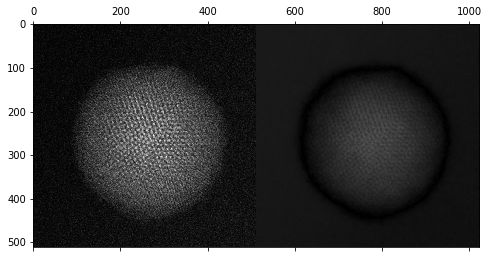

In [3]:
plt.matshow(np.hstack((data_4_0_normalised, data_4_ns_approx_v2)))

In [4]:
[data_4_ns_approx_v2.min(), data_4_ns_approx_v2.mean(), data_4_ns_approx_v2.max()]

[0, 0.0, 0]

# Applying a displacement field

#### `ipm.apply_displacement_field( displacements: np.array, arr_2d_in: np.array, debug=False )`

Apply a displacement field to an image.

`displacements` (numpy array of shape (2, height, width)) is a pair of displacement fields: the first is vertical and the second is horizontal.

`arr_2d_in` (numpy array of shape (height, width)) is the image to which the displacement field will be applied.

A list of length 2 is returned. The first element is a displaced image (numpy array of shape (height, width)). The second element is a "sum of weights" matrix (used for debugging).

In [5]:
[shifted_A1, sow_A1] = ipm.apply_displacement_field(vfield_1, arr_A)
[shifted_A2, sow_A2] = ipm.apply_displacement_field(vfield_2, arr_A)
[shifted_A3, sow_A3] = ipm.apply_displacement_field(vfield_3, arr_A)

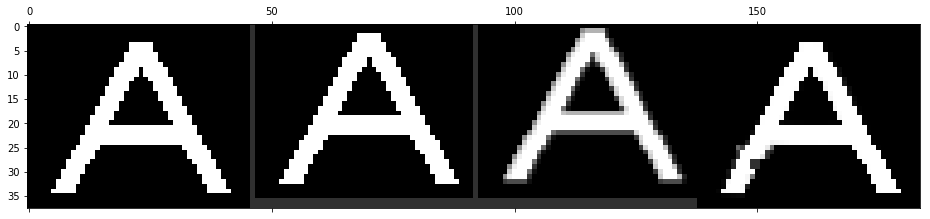

In [9]:
plt.matshow(np.hstack((arr_A, shifted_A1, shifted_A2, shifted_A3)))

#### `ipm.apply_displacement_field_sitk( displacements: np.array, arr_2d_in: np.array, rearrange=True )`

Apply a displacement field using SimpleITK.

A displaced image (numpy array of shape (height, width)) is returned.

In [7]:
shifted_A1_sitk = ipm.apply_displacement_field_sitk(vfield_1, arr_A)
shifted_A2_sitk = ipm.apply_displacement_field_sitk(vfield_2, arr_A)
shifted_A3_sitk = ipm.apply_displacement_field_sitk(vfield_3, arr_A)

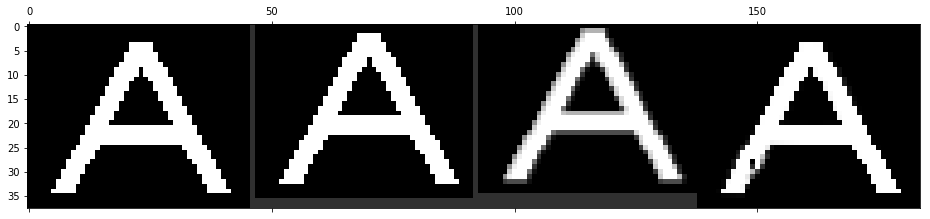

In [10]:
plt.matshow(np.hstack((arr_A, shifted_A1_sitk, shifted_A2_sitk, shifted_A3_sitk)))

Note that there are differences between `shifted_A2` and `shifted_A2_sitk`, and between `shifted_A3` and `shifted_A3_sitk`. The SITK method for applying a displacement field will henceforth be used instead of `ipm.apply_displacement_field`.

# Rigid registration

## Translation estimation

#### `hs.signals.Signal2D.estimate_shift2D( reference='current', correlation_threshold=None, chunk_size=30, roi=None, normalize_corr=False, sobel=True, medfilter=True, hanning=True, plot=False, dtype='float', show_progressbar=None, sub_pixel_factor=1 )`

#### Estimate shifts relative to the first image in the stack

In [4]:
shifts_1 = signal_1.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=50)
shifts_2 = signal_2.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=50)
shifts_3 = signal_3.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=50)
shifts_4 = signal_4.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=50)
shifts_5 = signal_5.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=50)
shifts_A = signal_A.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=50)

/dls_sw/apps/python/anaconda/1.7.0/64/envs/python3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


#### Correct for estimated shifts

In [5]:
signal_1_shifted = ipm.correct_shifts_vh(signal_1, shifts_1)
signal_2_shifted = ipm.correct_shifts_vh(signal_2, shifts_2)
signal_3_shifted = ipm.correct_shifts_vh(signal_3, shifts_3)
signal_4_shifted = ipm.correct_shifts_vh(signal_4, shifts_4)
signal_5_shifted = ipm.correct_shifts_vh(signal_5, shifts_5)
signal_A_shifted = ipm.correct_shifts_vh(signal_A, shifts_A)

#### Display original and shifted signals

In [6]:
%matplotlib qt
hs.plot.plot_signals([signal_1, signal_1_shifted])

In [9]:
%matplotlib qt
hs.plot.plot_signals([signal_2, signal_2_shifted])

In [ ]:
%matplotlib qt
hs.plot.plot_signals([signal_3, signal_3_shifted])

In [8]:
%matplotlib qt
hs.plot.plot_signals([signal_4, signal_4_shifted])

In [ ]:
%matplotlib qt
hs.plot.plot_signals([signal_5, signal_5_shifted])

In [7]:
%matplotlib qt
hs.plot.plot_signals([signal_A, signal_A_shifted])

#### `ipm.estimate_shift_relative_to_most_representative_image(signal_in: hs.signals.Signal2D, exponent=1, sub_pixel_factor=50)`

#### Estimate shifts

The "most representative" image is determined using `ipm.highest_mutual_information_index`.

In [8]:
shifts_1_v2 = ipm.estimate_shift_relative_to_most_representative_image(signal_1)
shifts_2_v2 = ipm.estimate_shift_relative_to_most_representative_image(signal_2)
shifts_3_v2 = ipm.estimate_shift_relative_to_most_representative_image(signal_3)
shifts_4_v2 = ipm.estimate_shift_relative_to_most_representative_image(signal_4)
shifts_5_v2 = ipm.estimate_shift_relative_to_most_representative_image(signal_5)
shifts_A_v2 = ipm.estimate_shift_relative_to_most_representative_image(signal_A)

#### Correct for estimated shifts

In [9]:
signal_1_shifted_v2 = ipm.correct_shifts_vh(signal_1, shifts_1_v2)
signal_2_shifted_v2 = ipm.correct_shifts_vh(signal_2, shifts_2_v2)
signal_3_shifted_v2 = ipm.correct_shifts_vh(signal_3, shifts_3_v2)
signal_4_shifted_v2 = ipm.correct_shifts_vh(signal_4, shifts_4_v2)
signal_5_shifted_v2 = ipm.correct_shifts_vh(signal_5, shifts_5_v2)
signal_A_shifted_v2 = ipm.correct_shifts_vh(signal_A, shifts_A_v2)

#### Display original and shifted signals

In [10]:
%matplotlib qt
hs.plot.plot_signals([signal_1, signal_1_shifted_v2])

In [11]:
%matplotlib qt
hs.plot.plot_signals([signal_A, signal_A_shifted_v2])

## Affine registration

#### `scale(arr_in: np.array, scale_factor_x=1.0, scale_factor_y=1.0)`

In [63]:
arr_A_scaled = ipm.scale(arr_A, 0.5, 0.8)

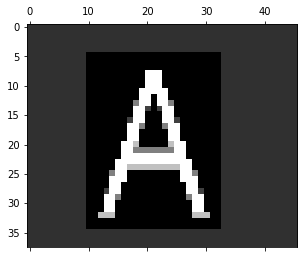

In [5]:
plt.matshow(arr_A_scaled)

In [6]:
arr_A_scaled[10]

array([0.19050343, 0.19050343, 0.19050343, 0.19050343, 0.19050343,
       0.19050343, 0.19050343, 0.19050343, 0.19050343, 0.19050343,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.19050343, 0.19050343,
       0.19050343, 0.19050343, 0.19050343, 0.19050343, 0.19050343,
       0.19050343, 0.19050343, 0.19050343, 0.19050343, 0.19050343,
       0.19050343])

In [9]:
data_1_0_scaled = ipm.scale(signal_1.data[0], 0.5, 0.8)

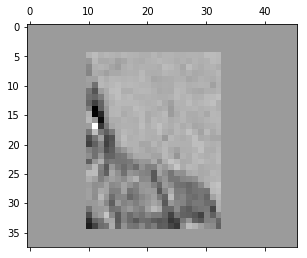

In [10]:
plt.matshow(data_1_0_scaled)

#### `optimise_scale(arr_moving: np.array, arr_ref: np.array, initial_guess_x=1.0, initial_guess_y=1.0)`

In [64]:
scale_optimisation_result = ipm.optimise_scale(arr_A, arr_A_scaled)

In [12]:
scale_optimisation_result

array([0.50048838, 0.80148497])

In [65]:
scale_x = scale_optimisation_result[0]
scale_y = scale_optimisation_result[1]
arr_A_scaled_2 = ipm.scale(arr_A, scale_x, scale_y)

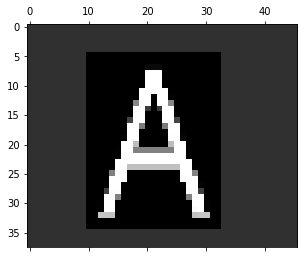

In [14]:
plt.matshow(arr_A_scaled_2)

#### Rigid registration + `optimise_scale`

In [66]:
shifts_2_v2 = ipm.estimate_shift_relative_to_most_representative_image(signal_2)
signal_2_shifted_v2 = hs.signals.Signal2D(np.empty_like(signal_2.data))
for t in range(signal_2.data.shape[0]):
    vfield = np.array([np.ones_like(signal_2.data[t]) * -shifts_2_v2[t][0], np.ones_like(signal_2.data[t]) * -shifts_2_v2[t][1]])
    signal_2_shifted_v2.data[t] = ipm.apply_displacement_field_sitk(vfield, signal_2.data[t])
max_mi_index = ipm.highest_mutual_information_index(signal_2_shifted_v2)
signal_2_shifted_v2_scaled = hs.signals.Signal2D(np.empty_like(signal_2.data))
scale_data = []
for t in range(signal_2.data.shape[0]):
    scale_result = ipm.optimise_scale(signal_2_shifted_v2.data[t], signal_2_shifted_v2.data[max_mi_index])
    signal_2_shifted_v2_scaled.data[t] = ipm.scale(signal_2_shifted_v2.data[t], scale_result.x[0], scale_result.x[1])
    scale_data.append(scale_result.x)

/dls_sw/apps/python/anaconda/1.7.0/64/envs/python3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


#### Plots of estimated scale parameter values

In [5]:
x_scales = np.array(scale_data).T[0]
y_scales = np.array(scale_data).T[1]

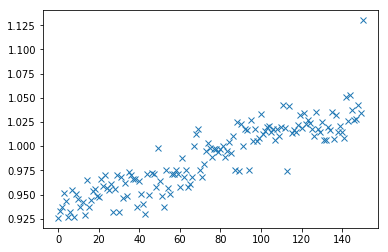

In [10]:
plt.plot(x_scales, 'x')

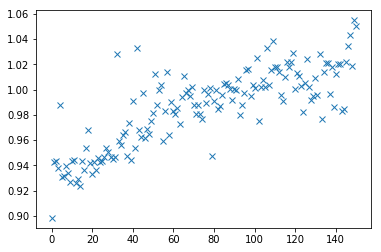

In [11]:
plt.plot(y_scales, 'x')

In [55]:
%matplotlib qt
hs.plot.plot_signals([signal_2, signal_2_shifted_v2_scaled])

#### Perform nonrigid registration on `signal_2_shifted_v2_scaled`

In [67]:
signal_2_shifted_v2_scaled_nonrigid = hs.signals.Signal2D(ipm.nonrigid(signal_2_shifted_v2_scaled.data, demons_it = 20, filter_size = 5.0, max_it = 3, default_pixel_value = signal_2_shifted_v2_scaled.data[0].mean()))

#### Compare unmodified, shifted, shifted & scaled, shifted & scaled & nonrigid registered

In [68]:
%matplotlib qt
hs.plot.plot_signals([signal_2, signal_2_shifted_v2, signal_2_shifted_v2_scaled, signal_2_shifted_v2_scaled_nonrigid])

### "Simple" affine transformation: rotation and scaling only, scale_x = scale_y

In [11]:
scale_simple = 0.8
rotation_simple = -math.pi/12
#arr_A_affine_simple = skimage.transform.warp(arr_A, skimage.transform.AffineTransform(matrix=np.array([[scale_simple * math.cos(rotation_simple), -scale_simple * math.sin(rotation_simple), 0], [scale_simple * math.sin(rotation_simple), scale_simple * math.cos(rotation_simple), 0], [0, 0, 1]])).inverse)
arr_A_affine_simple = ipm.transform_using_values(arr_A, [scale_simple, scale_simple, 0, rotation_simple, 0, 0])

In [12]:
plt.matshow(arr_A_affine_simple)

#### Calculate mutual information between transformed `arr_A` and reference image (`arr_A_affine_simple`) for a range of scale and rotation values

In [19]:
scale_min = 0.1
scale_max = 2
rotation_min = -math.pi
rotation_max = math.pi
num_scales = 100
num_rotations = 100
#tformed = np.array((num_scales, num_rotations, arr_A.shape[0], arr_A.shape[1]))
tformed = []
for i in range(num_scales):
    tformed.append([])
    scale_current = scale_min + (scale_max - scale_min) * i/(num_scales-1)
    for j in range(num_rotations):
        rotation_current = rotation_min + (rotation_max - rotation_min) * j/(num_rotations-1)
        #tformed[i][j] = skimage.transform.warp(arr_A, skimage.transform.AffineTransform(matrix=np.array([[scale_current * math.cos(rotation_current), -scale_current * math.sin(rotation_current), 0], [scale_current * math.sin(rotation_current), scale_current * math.cos(rotation_current), 0], [0, 0, 1]])).inverse)
        #tformed[i].append(skimage.transform.warp(arr_A, skimage.transform.AffineTransform(matrix=np.array([[scale_current * math.cos(rotation_current), -scale_current * math.sin(rotation_current), 0], [scale_current * math.sin(rotation_current), scale_current * math.cos(rotation_current), 0], [0, 0, 1]])).inverse))
        tformed[i].append(ipm.transform_using_values(arr_A, [scale_current, scale_current, 0, rotation_current, 0, 0]))
#tformed_mi = np.array((num_scales, num_rotations))
tformed_mi = []
for i in range(num_scales):
    tformed_mi.append([])
    for j in range(num_rotations):
        #tformed_mi[i][j] = ipm.mutual_information(tformed[i][j], arr_A_affine_simple)
        tformed_mi[i].append(ipm.mutual_information(tformed[i][j], arr_A_affine_simple))
arr_mi = np.array(tformed_mi)

#### Plot mutual information as calculated above (intensity) against scale factor (vertical axis) and rotation (horizontal axis)

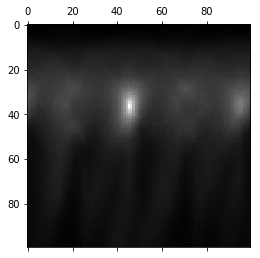

In [41]:
plt.matshow(arr_mi)

In [20]:
plt.matshow(arr_mi)

#### "Moving" image (left) and "reference" image (right)

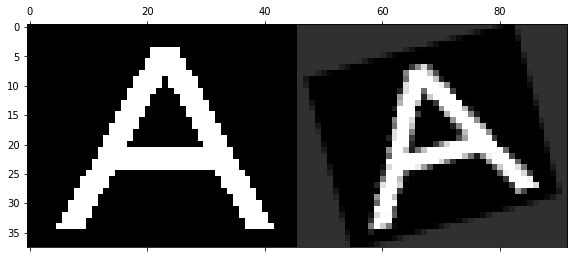

In [42]:
plt.matshow(np.hstack((arr_A, arr_A_affine_simple)))

#### Print estimated and true scale and rotation values
The values estimated are reasonably close to the true values.

In [43]:
(opt_i, opt_j) = np.unravel_index(np.argmax(arr_mi), arr_mi.shape)
opt_scale = scale_min + (scale_max - scale_min) * opt_i/num_scales
opt_rotation = rotation_min + (rotation_max - rotation_min) * opt_j/num_rotations
[[opt_scale, opt_rotation], [scale_simple, rotation_simple]]

[[0.7839999999999999, -0.3141592653589793], [0.8, -0.2617993877991494]]

#### Compare mutual information between transformed image and reference image with the MI of the reference image with itself

In [44]:
[ipm.mutual_information(tformed[opt_i][opt_j], arr_A_affine_simple), ipm.mutual_information(arr_A_affine_simple, arr_A_affine_simple)]

[0.7676894916116072, 0.9999999999999999]

#### Transformed image, using estimated parameter values

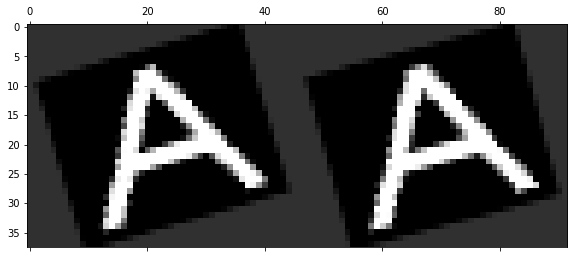

In [45]:
plt.matshow(np.hstack((tformed[opt_i][opt_j], arr_A_affine_simple)))

## Rigid registration by estimating shifts on the image after upsampling and conversion to log-polar coordinates

#### `cartesian_to_log_polar(arr_in: np.array)`

In [2]:
arr_A_log_polar = ipm.cartesian_to_log_polar(skimage.transform.resize(arr_A, (arr_A.shape[0]*64.0, arr_A.shape[1]*64.0), mode='reflect', anti_aliasing=True))

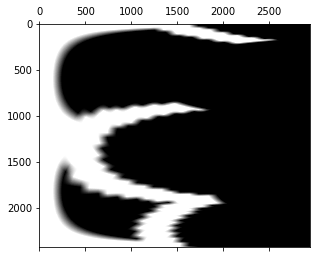

In [3]:
plt.matshow(arr_A_log_polar)

In [42]:
data_1_0_log_polar = ipm.cartesian_to_log_polar(skimage.transform.resize(
    signal_1.data[0], (signal_1.data.shape[1]*64.0, signal_1.data.shape[2]*64.0), mode='reflect', anti_aliasing=True))

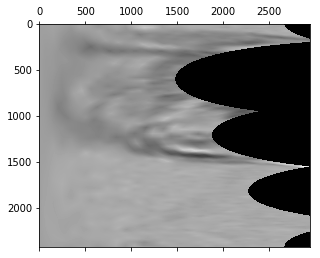

In [43]:
plt.matshow(data_1_0_log_polar)

#### `log_polar_to_cartesian(arr_in: np.array)`

In [46]:
arr_A_cartesian = ipm.log_polar_to_cartesian(arr_A_log_polar)

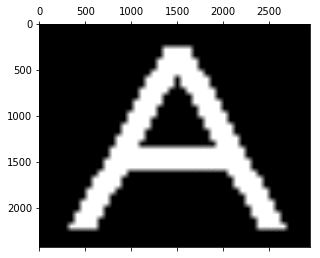

In [47]:
plt.matshow(arr_A_cartesian)

In [48]:
arr_A_cartesian_downsampled = skimage.transform.resize(arr_A_cartesian, arr_A.shape, mode='reflect', anti_aliasing=False)

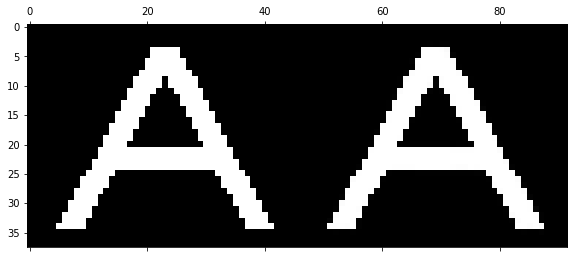

In [49]:
plt.matshow(np.hstack((arr_A, arr_A_cartesian_downsampled)))

In [50]:
data_1_0_cartesian = ipm.log_polar_to_cartesian(data_1_0_log_polar)

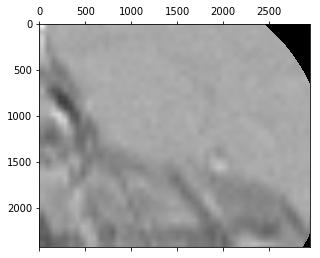

In [51]:
plt.matshow(data_1_0_cartesian)

In [52]:
data_1_0_cartesian_downsampled = skimage.transform.resize(data_1_0_cartesian, signal_1.data[0].shape, mode='reflect', anti_aliasing=False)

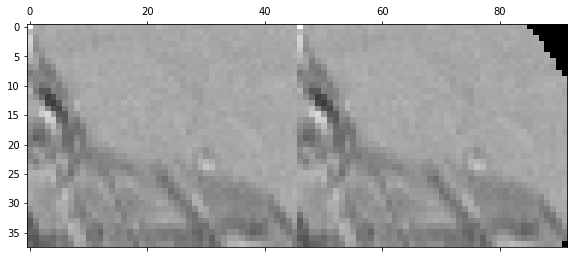

In [54]:
plt.matshow(np.hstack((signal_1.data[0], data_1_0_cartesian_downsampled)))

#### Apply rigid registration to log-polar image

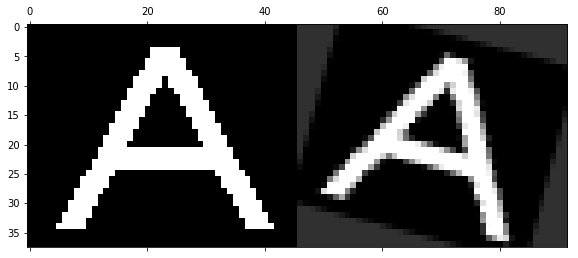

In [126]:
#arr_A_scaled_and_rotated = ipm.transform_using_values(arr_A, [0.85, 0.85, 0, math.pi/12, 0, 0])
scale = 0.9
rotation = 1*math.pi/12
arr_A_scaled_and_rotated = ipm.transform_using_values(arr_A, [scale, scale, 0, rotation, 0, 0])
plt.matshow(np.hstack((arr_A, arr_A_scaled_and_rotated)))

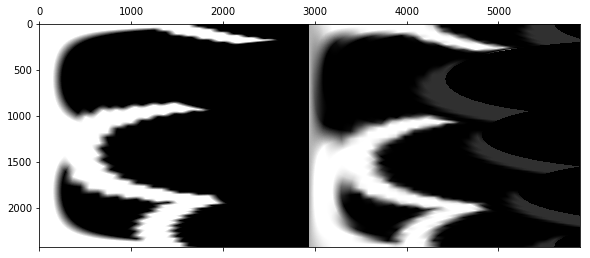

In [127]:
arr_A_scaled_and_rotated_log_polar = ipm.cartesian_to_log_polar(skimage.transform.resize(
    arr_A_scaled_and_rotated, (arr_A_scaled_and_rotated.shape[0]*64.0, arr_A_scaled_and_rotated.shape[1]*64.0), mode='reflect', anti_aliasing=True))
plt.matshow(np.hstack((arr_A_log_polar, arr_A_scaled_and_rotated_log_polar)))

In [128]:
#signal_log_polar = hs.signals.Signal2D(np.array([arr_A_log_polar, arr_A_scaled_and_rotated_log_polar]))
#shifts_log_polar = signal_log_polar.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=32)
#signal_log_polar_shifted = ipm.correct_shifts_vh(signal_log_polar, shifts_log_polar)
#arr_A_scaled_and_rotated_log_polar_shifted = signal_log_polar_shifted.data[1]
smaller_scale_factor = 8
downsampled_h = arr_A_scaled_and_rotated.shape[0]*smaller_scale_factor
downsampled_w = arr_A_scaled_and_rotated.shape[1]*smaller_scale_factor
arr_A_log_polar_downsampled = skimage.transform.resize(arr_A_log_polar, (downsampled_h, downsampled_w), mode='reflect', anti_aliasing=True)
arr_A_scaled_and_rotated_log_polar_downsampled = skimage.transform.resize(arr_A_scaled_and_rotated_log_polar, (downsampled_h, downsampled_w), mode='reflect', anti_aliasing=True)
signal_log_polar = hs.signals.Signal2D(np.array([arr_A_log_polar_downsampled, arr_A_scaled_and_rotated_log_polar_downsampled]))

In [129]:
shifts_log_polar = signal_log_polar.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=32)
signal_log_polar_shifted = ipm.correct_shifts_vh(signal_log_polar, shifts_log_polar)

In [130]:
arr_A_scaled_and_rotated_log_polar_shifted = skimage.transform.resize(signal_log_polar_shifted.data[1], (arr_A_scaled_and_rotated.shape[0]*64, arr_A_scaled_and_rotated.shape[1]*64), mode='reflect', anti_aliasing=True)

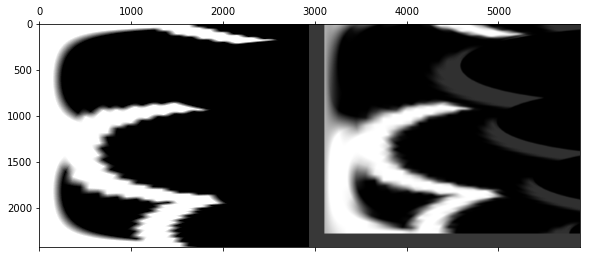

In [131]:
plt.matshow(np.hstack((arr_A_log_polar, arr_A_scaled_and_rotated_log_polar_shifted)))

In [293]:
frac_v_shift = shifts_log_polar[1][0] / downsampled_h
frac_h_shift = shifts_log_polar[1][1] / downsampled_w
print("Fractional vertical shift (rotation, positive is clockwise): " + str(frac_v_shift))
print("Fractional horizontal shift (scale, positive is scaling-up): " + str(frac_h_shift))

Fractional vertical shift (rotation, positive is clockwise): 0.06034128289473684
Fractional horizontal shift (scale, positive is scaling-up): -0.05528192934782609


In [133]:
print(str(shifts_log_polar[1][0] / downsampled_h) + " / " + str(rotation) + " = " + str(shifts_log_polar[1][0] / (downsampled_h * rotation)) + " (rotation)")
print(str(shifts_log_polar[1][1] / downsampled_w) + " / " + str(scale) + " = " + str(shifts_log_polar[1][1] / (downsampled_w * scale)) + " (scale)")
scale_change = scale - 1
print(str(shifts_log_polar[1][1] / downsampled_w) + " / " + str(scale_change) + " = " + str(shifts_log_polar[1][1] / (downsampled_w * scale_change)) + " (scale_change)")

# 0.06548108552631579  / 0.2617993877991494   = 0.2501193225728717    (rotation)
# 0.11973505434782608  / 1.3                  = 0.09210388795986621   (scale)
# 0.11973505434782608 / 0.30000000000000004   = 0.39911684782608686   (scale_change)
# ---
# 0.055818256578947366 / 0.2617993877991494   = 0.21321003478346837   (rotation)
# 0.07685122282608696  / 1.1                  = 0.06986474802371541   (scale)
# 0.07685122282608696  / 0.10000000000000009  = 0.7685122282608688    (scale_change)
# ---
# 0.06034128289473684  / 0.2617993877991494   = 0.2304867226848912    (rotation)
# -0.05528192934782609 / 0.9                  = -0.061424365942028984 (scale)
# -0.05528192934782609 / -0.09999999999999998 = 0.552819293478261     (scale_change)
# ---
# 0.06702302631578948  / 0.2617993877991494   = 0.2560091025392659    (rotation)
# -0.19403872282608695 / 0.7                  = -0.2771981754658385   (scale)
# -0.19403872282608695 / -0.30000000000000004 = 0.6467957427536231    (scale_change)
# ===
# 0.055818256578947366 / 0.2617993877991494   = 0.21321003478346837   (rotation)
# 0.07685122282608696  / 1.1                  = 0.06986474802371541   (scale)
# 0.07685122282608696  / 0.10000000000000009  = 0.7685122282608688    (scale_change)
# ---
# 0.11266447368421052  / 0.5235987755982988   = 0.2151732947722664    (rotation)
# 0.09315557065217392  / 1.1                  = 0.08468688241106719   (scale)
# 0.09315557065217392  / 0.10000000000000009  = 0.9315557065217384    (scale_change)
# ---
# 0.16879111842105263  / 0.7853981633974483   = 0.21491152677376      (rotation)
# 0.10945991847826086  / 1.1                  = 0.09950901679841898   (scale)
# 0.10945991847826086  / 0.10000000000000009  = 1.0945991847826078    (scale_change)
# ---

0.06034128289473684 / 0.2617993877991494 = 0.2304867226848912 (rotation)
-0.05528192934782609 / 0.9 = -0.061424365942028984 (scale)
-0.05528192934782609 / -0.09999999999999998 = 0.552819293478261 (scale_change)


In [200]:
larger_upsampling_factor = 64
smaller_upsampling_factor = 8
larger_h = arr_A.shape[0] * larger_upsampling_factor
larger_w = arr_A.shape[1] * larger_upsampling_factor
smaller_h = arr_A.shape[0] * smaller_upsampling_factor
smaller_w = arr_A.shape[1] * smaller_upsampling_factor

num_rotations = 15
num_scales = 15
rotations = ((np.arange(num_rotations) - (num_rotations-1)/2)/((num_rotations-1)/2)) * math.pi/6
scales = ((np.arange(num_scales) - (num_scales-1)/2)/((num_scales-1)/2)) * 0.2 + 1

# Rotation
fractional_vertical_shifts = np.empty((num_rotations, num_scales))
# Scale
fractional_horizontal_shifts = np.empty((num_rotations, num_scales))

arr_A_log_polar_downsampled = skimage.transform.resize(arr_A_log_polar, (smaller_h, smaller_w), mode='reflect', anti_aliasing=True)

for i in range(num_rotations):
    for j in range(num_scales):
        rotation = rotations[i]
        scale = scales[j]
        print(str((i, j)) + ": rotation = " + str(rotation) + ", scale = " + str(scale))
        arr_A_sr = ipm.transform_using_values(arr_A, [scale, scale, 0, rotation, 0, 0])

        arr_A_sr_lp = ipm.cartesian_to_log_polar(skimage.transform.resize(
            arr_A_sr, (larger_h, larger_w), mode='reflect', anti_aliasing=True))
        
        arr_A_sr_lp_downsampled = skimage.transform.resize(arr_A_sr_lp, (smaller_h, smaller_w), mode='reflect', anti_aliasing=True)
        signal_lp = hs.signals.Signal2D(np.array([arr_A_log_polar_downsampled, arr_A_sr_lp_downsampled]))
        
        shifts_lp = signal_lp.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=32)
        fractional_vertical_shifts[i][j] = shifts_lp[1][0] / smaller_h
        fractional_horizontal_shifts[i][j] = shifts_lp[1][1] / smaller_w

(0, 0): rotation = -0.5235987755982988, scale = 0.8



(0, 1): rotation = -0.5235987755982988, scale = 0.8285714285714285



(0, 2): rotation = -0.5235987755982988, scale = 0.8571428571428571



(0, 3): rotation = -0.5235987755982988, scale = 0.8857142857142857



(0, 4): rotation = -0.5235987755982988, scale = 0.9142857142857143



(0, 5): rotation = -0.5235987755982988, scale = 0.9428571428571428



(0, 6): rotation = -0.5235987755982988, scale = 0.9714285714285714



(0, 7): rotation = -0.5235987755982988, scale = 1.0



(0, 8): rotation = -0.5235987755982988, scale = 1.0285714285714285



(0, 9): rotation = -0.5235987755982988, scale = 1.0571428571428572



(0, 10): rotation = -0.5235987755982988, scale = 1.0857142857142856



(0, 11): rotation = -0.5235987755982988, scale = 1.1142857142857143



(0, 12): rotation = -0.5235987755982988, scale = 1.1428571428571428



(0, 13): rotation = -0.5235987755982988, scale = 1.1714285714285715



(0, 14): rotation = -0.5235987755982988, scale = 1.2



(1, 0): rotation = -0.4487989505128276, scale = 0.8



(1, 1): rotation = -0.4487989505128276, scale = 0.8285714285714285



(1, 2): rotation = -0.4487989505128276, scale = 0.8571428571428571



(1, 3): rotation = -0.4487989505128276, scale = 0.8857142857142857



(1, 4): rotation = -0.4487989505128276, scale = 0.9142857142857143



(1, 5): rotation = -0.4487989505128276, scale = 0.9428571428571428



(1, 6): rotation = -0.4487989505128276, scale = 0.9714285714285714



(1, 7): rotation = -0.4487989505128276, scale = 1.0



(1, 8): rotation = -0.4487989505128276, scale = 1.0285714285714285



(1, 9): rotation = -0.4487989505128276, scale = 1.0571428571428572



(1, 10): rotation = -0.4487989505128276, scale = 1.0857142857142856



(1, 11): rotation = -0.4487989505128276, scale = 1.1142857142857143



(1, 12): rotation = -0.4487989505128276, scale = 1.1428571428571428



(1, 13): rotation = -0.4487989505128276, scale = 1.1714285714285715



(1, 14): rotation = -0.4487989505128276, scale = 1.2



(2, 0): rotation = -0.3739991254273563, scale = 0.8



(2, 1): rotation = -0.3739991254273563, scale = 0.8285714285714285



(2, 2): rotation = -0.3739991254273563, scale = 0.8571428571428571



(2, 3): rotation = -0.3739991254273563, scale = 0.8857142857142857



(2, 4): rotation = -0.3739991254273563, scale = 0.9142857142857143



(2, 5): rotation = -0.3739991254273563, scale = 0.9428571428571428



(2, 6): rotation = -0.3739991254273563, scale = 0.9714285714285714



(2, 7): rotation = -0.3739991254273563, scale = 1.0



(2, 8): rotation = -0.3739991254273563, scale = 1.0285714285714285



(2, 9): rotation = -0.3739991254273563, scale = 1.0571428571428572



(2, 10): rotation = -0.3739991254273563, scale = 1.0857142857142856



(2, 11): rotation = -0.3739991254273563, scale = 1.1142857142857143



(2, 12): rotation = -0.3739991254273563, scale = 1.1428571428571428



(2, 13): rotation = -0.3739991254273563, scale = 1.1714285714285715



(2, 14): rotation = -0.3739991254273563, scale = 1.2



(3, 0): rotation = -0.2991993003418851, scale = 0.8



(3, 1): rotation = -0.2991993003418851, scale = 0.8285714285714285



(3, 2): rotation = -0.2991993003418851, scale = 0.8571428571428571



(3, 3): rotation = -0.2991993003418851, scale = 0.8857142857142857



(3, 4): rotation = -0.2991993003418851, scale = 0.9142857142857143



(3, 5): rotation = -0.2991993003418851, scale = 0.9428571428571428



(3, 6): rotation = -0.2991993003418851, scale = 0.9714285714285714



(3, 7): rotation = -0.2991993003418851, scale = 1.0



(3, 8): rotation = -0.2991993003418851, scale = 1.0285714285714285



(3, 9): rotation = -0.2991993003418851, scale = 1.0571428571428572



(3, 10): rotation = -0.2991993003418851, scale = 1.0857142857142856



(3, 11): rotation = -0.2991993003418851, scale = 1.1142857142857143



(3, 12): rotation = -0.2991993003418851, scale = 1.1428571428571428



(3, 13): rotation = -0.2991993003418851, scale = 1.1714285714285715



(3, 14): rotation = -0.2991993003418851, scale = 1.2



(4, 0): rotation = -0.2243994752564138, scale = 0.8



(4, 1): rotation = -0.2243994752564138, scale = 0.8285714285714285



(4, 2): rotation = -0.2243994752564138, scale = 0.8571428571428571



(4, 3): rotation = -0.2243994752564138, scale = 0.8857142857142857



(4, 4): rotation = -0.2243994752564138, scale = 0.9142857142857143



(4, 5): rotation = -0.2243994752564138, scale = 0.9428571428571428



(4, 6): rotation = -0.2243994752564138, scale = 0.9714285714285714



(4, 7): rotation = -0.2243994752564138, scale = 1.0



(4, 8): rotation = -0.2243994752564138, scale = 1.0285714285714285



(4, 9): rotation = -0.2243994752564138, scale = 1.0571428571428572



(4, 10): rotation = -0.2243994752564138, scale = 1.0857142857142856



(4, 11): rotation = -0.2243994752564138, scale = 1.1142857142857143



(4, 12): rotation = -0.2243994752564138, scale = 1.1428571428571428



(4, 13): rotation = -0.2243994752564138, scale = 1.1714285714285715



(4, 14): rotation = -0.2243994752564138, scale = 1.2



(5, 0): rotation = -0.14959965017094254, scale = 0.8



(5, 1): rotation = -0.14959965017094254, scale = 0.8285714285714285



(5, 2): rotation = -0.14959965017094254, scale = 0.8571428571428571



(5, 3): rotation = -0.14959965017094254, scale = 0.8857142857142857



(5, 4): rotation = -0.14959965017094254, scale = 0.9142857142857143



(5, 5): rotation = -0.14959965017094254, scale = 0.9428571428571428



(5, 6): rotation = -0.14959965017094254, scale = 0.9714285714285714



(5, 7): rotation = -0.14959965017094254, scale = 1.0



(5, 8): rotation = -0.14959965017094254, scale = 1.0285714285714285



(5, 9): rotation = -0.14959965017094254, scale = 1.0571428571428572



(5, 10): rotation = -0.14959965017094254, scale = 1.0857142857142856



(5, 11): rotation = -0.14959965017094254, scale = 1.1142857142857143



(5, 12): rotation = -0.14959965017094254, scale = 1.1428571428571428



(5, 13): rotation = -0.14959965017094254, scale = 1.1714285714285715



(5, 14): rotation = -0.14959965017094254, scale = 1.2



(6, 0): rotation = -0.07479982508547127, scale = 0.8



(6, 1): rotation = -0.07479982508547127, scale = 0.8285714285714285



(6, 2): rotation = -0.07479982508547127, scale = 0.8571428571428571



(6, 3): rotation = -0.07479982508547127, scale = 0.8857142857142857



(6, 4): rotation = -0.07479982508547127, scale = 0.9142857142857143



(6, 5): rotation = -0.07479982508547127, scale = 0.9428571428571428



(6, 6): rotation = -0.07479982508547127, scale = 0.9714285714285714



(6, 7): rotation = -0.07479982508547127, scale = 1.0



(6, 8): rotation = -0.07479982508547127, scale = 1.0285714285714285



(6, 9): rotation = -0.07479982508547127, scale = 1.0571428571428572



(6, 10): rotation = -0.07479982508547127, scale = 1.0857142857142856



(6, 11): rotation = -0.07479982508547127, scale = 1.1142857142857143



(6, 12): rotation = -0.07479982508547127, scale = 1.1428571428571428



(6, 13): rotation = -0.07479982508547127, scale = 1.1714285714285715



(6, 14): rotation = -0.07479982508547127, scale = 1.2



(7, 0): rotation = 0.0, scale = 0.8



(7, 1): rotation = 0.0, scale = 0.8285714285714285



(7, 2): rotation = 0.0, scale = 0.8571428571428571



(7, 3): rotation = 0.0, scale = 0.8857142857142857



(7, 4): rotation = 0.0, scale = 0.9142857142857143



(7, 5): rotation = 0.0, scale = 0.9428571428571428



(7, 6): rotation = 0.0, scale = 0.9714285714285714



(7, 7): rotation = 0.0, scale = 1.0



(7, 8): rotation = 0.0, scale = 1.0285714285714285



(7, 9): rotation = 0.0, scale = 1.0571428571428572



(7, 10): rotation = 0.0, scale = 1.0857142857142856



(7, 11): rotation = 0.0, scale = 1.1142857142857143



(7, 12): rotation = 0.0, scale = 1.1428571428571428



(7, 13): rotation = 0.0, scale = 1.1714285714285715



(7, 14): rotation = 0.0, scale = 1.2



(8, 0): rotation = 0.07479982508547127, scale = 0.8



(8, 1): rotation = 0.07479982508547127, scale = 0.8285714285714285



(8, 2): rotation = 0.07479982508547127, scale = 0.8571428571428571



(8, 3): rotation = 0.07479982508547127, scale = 0.8857142857142857



(8, 4): rotation = 0.07479982508547127, scale = 0.9142857142857143



(8, 5): rotation = 0.07479982508547127, scale = 0.9428571428571428



(8, 6): rotation = 0.07479982508547127, scale = 0.9714285714285714



(8, 7): rotation = 0.07479982508547127, scale = 1.0



(8, 8): rotation = 0.07479982508547127, scale = 1.0285714285714285



(8, 9): rotation = 0.07479982508547127, scale = 1.0571428571428572



(8, 10): rotation = 0.07479982508547127, scale = 1.0857142857142856



(8, 11): rotation = 0.07479982508547127, scale = 1.1142857142857143



(8, 12): rotation = 0.07479982508547127, scale = 1.1428571428571428



(8, 13): rotation = 0.07479982508547127, scale = 1.1714285714285715



(8, 14): rotation = 0.07479982508547127, scale = 1.2



(9, 0): rotation = 0.14959965017094254, scale = 0.8



(9, 1): rotation = 0.14959965017094254, scale = 0.8285714285714285



(9, 2): rotation = 0.14959965017094254, scale = 0.8571428571428571



(9, 3): rotation = 0.14959965017094254, scale = 0.8857142857142857



(9, 4): rotation = 0.14959965017094254, scale = 0.9142857142857143



(9, 5): rotation = 0.14959965017094254, scale = 0.9428571428571428



(9, 6): rotation = 0.14959965017094254, scale = 0.9714285714285714



(9, 7): rotation = 0.14959965017094254, scale = 1.0



(9, 8): rotation = 0.14959965017094254, scale = 1.0285714285714285



(9, 9): rotation = 0.14959965017094254, scale = 1.0571428571428572



(9, 10): rotation = 0.14959965017094254, scale = 1.0857142857142856



(9, 11): rotation = 0.14959965017094254, scale = 1.1142857142857143



(9, 12): rotation = 0.14959965017094254, scale = 1.1428571428571428



(9, 13): rotation = 0.14959965017094254, scale = 1.1714285714285715



(9, 14): rotation = 0.14959965017094254, scale = 1.2



(10, 0): rotation = 0.2243994752564138, scale = 0.8



(10, 1): rotation = 0.2243994752564138, scale = 0.8285714285714285



(10, 2): rotation = 0.2243994752564138, scale = 0.8571428571428571



(10, 3): rotation = 0.2243994752564138, scale = 0.8857142857142857



(10, 4): rotation = 0.2243994752564138, scale = 0.9142857142857143



(10, 5): rotation = 0.2243994752564138, scale = 0.9428571428571428



(10, 6): rotation = 0.2243994752564138, scale = 0.9714285714285714



(10, 7): rotation = 0.2243994752564138, scale = 1.0



(10, 8): rotation = 0.2243994752564138, scale = 1.0285714285714285



(10, 9): rotation = 0.2243994752564138, scale = 1.0571428571428572



(10, 10): rotation = 0.2243994752564138, scale = 1.0857142857142856



(10, 11): rotation = 0.2243994752564138, scale = 1.1142857142857143



(10, 12): rotation = 0.2243994752564138, scale = 1.1428571428571428



(10, 13): rotation = 0.2243994752564138, scale = 1.1714285714285715



(10, 14): rotation = 0.2243994752564138, scale = 1.2



(11, 0): rotation = 0.2991993003418851, scale = 0.8



(11, 1): rotation = 0.2991993003418851, scale = 0.8285714285714285



(11, 2): rotation = 0.2991993003418851, scale = 0.8571428571428571



(11, 3): rotation = 0.2991993003418851, scale = 0.8857142857142857



(11, 4): rotation = 0.2991993003418851, scale = 0.9142857142857143



(11, 5): rotation = 0.2991993003418851, scale = 0.9428571428571428



(11, 6): rotation = 0.2991993003418851, scale = 0.9714285714285714



(11, 7): rotation = 0.2991993003418851, scale = 1.0



(11, 8): rotation = 0.2991993003418851, scale = 1.0285714285714285



(11, 9): rotation = 0.2991993003418851, scale = 1.0571428571428572



(11, 10): rotation = 0.2991993003418851, scale = 1.0857142857142856



(11, 11): rotation = 0.2991993003418851, scale = 1.1142857142857143



(11, 12): rotation = 0.2991993003418851, scale = 1.1428571428571428



(11, 13): rotation = 0.2991993003418851, scale = 1.1714285714285715



(11, 14): rotation = 0.2991993003418851, scale = 1.2



(12, 0): rotation = 0.3739991254273563, scale = 0.8



(12, 1): rotation = 0.3739991254273563, scale = 0.8285714285714285



(12, 2): rotation = 0.3739991254273563, scale = 0.8571428571428571



(12, 3): rotation = 0.3739991254273563, scale = 0.8857142857142857



(12, 4): rotation = 0.3739991254273563, scale = 0.9142857142857143



(12, 5): rotation = 0.3739991254273563, scale = 0.9428571428571428



(12, 6): rotation = 0.3739991254273563, scale = 0.9714285714285714



(12, 7): rotation = 0.3739991254273563, scale = 1.0



(12, 8): rotation = 0.3739991254273563, scale = 1.0285714285714285



(12, 9): rotation = 0.3739991254273563, scale = 1.0571428571428572



(12, 10): rotation = 0.3739991254273563, scale = 1.0857142857142856



(12, 11): rotation = 0.3739991254273563, scale = 1.1142857142857143



(12, 12): rotation = 0.3739991254273563, scale = 1.1428571428571428



(12, 13): rotation = 0.3739991254273563, scale = 1.1714285714285715



(12, 14): rotation = 0.3739991254273563, scale = 1.2



(13, 0): rotation = 0.4487989505128276, scale = 0.8



(13, 1): rotation = 0.4487989505128276, scale = 0.8285714285714285



(13, 2): rotation = 0.4487989505128276, scale = 0.8571428571428571



(13, 3): rotation = 0.4487989505128276, scale = 0.8857142857142857



(13, 4): rotation = 0.4487989505128276, scale = 0.9142857142857143



(13, 5): rotation = 0.4487989505128276, scale = 0.9428571428571428



(13, 6): rotation = 0.4487989505128276, scale = 0.9714285714285714



(13, 7): rotation = 0.4487989505128276, scale = 1.0



(13, 8): rotation = 0.4487989505128276, scale = 1.0285714285714285



(13, 9): rotation = 0.4487989505128276, scale = 1.0571428571428572



(13, 10): rotation = 0.4487989505128276, scale = 1.0857142857142856



(13, 11): rotation = 0.4487989505128276, scale = 1.1142857142857143



(13, 12): rotation = 0.4487989505128276, scale = 1.1428571428571428



(13, 13): rotation = 0.4487989505128276, scale = 1.1714285714285715



(13, 14): rotation = 0.4487989505128276, scale = 1.2



(14, 0): rotation = 0.5235987755982988, scale = 0.8



(14, 1): rotation = 0.5235987755982988, scale = 0.8285714285714285



(14, 2): rotation = 0.5235987755982988, scale = 0.8571428571428571



(14, 3): rotation = 0.5235987755982988, scale = 0.8857142857142857



(14, 4): rotation = 0.5235987755982988, scale = 0.9142857142857143



(14, 5): rotation = 0.5235987755982988, scale = 0.9428571428571428



(14, 6): rotation = 0.5235987755982988, scale = 0.9714285714285714



(14, 7): rotation = 0.5235987755982988, scale = 1.0



(14, 8): rotation = 0.5235987755982988, scale = 1.0285714285714285



(14, 9): rotation = 0.5235987755982988, scale = 1.0571428571428572



(14, 10): rotation = 0.5235987755982988, scale = 1.0857142857142856



(14, 11): rotation = 0.5235987755982988, scale = 1.1142857142857143



(14, 12): rotation = 0.5235987755982988, scale = 1.1428571428571428



(14, 13): rotation = 0.5235987755982988, scale = 1.1714285714285715



(14, 14): rotation = 0.5235987755982988, scale = 1.2


In [197]:
# f.h.s. against scale for rotation = math.pi/12
fractional_horizontal_shifts[3]
# -0.12746264, -0.05528193,  0.01537024,  0.07685122,  0.12423573

array([-0.12746264, -0.05528193,  0.01537024,  0.07685122,  0.12423573])

In [198]:
# f.v.s. against rotation for scale = 1.1
fractional_vertical_shifts.T[3]
# -0.08758224, -0.04533306, -0.        ,  0.05581826,  0.11266447

array([-0.08758224, -0.04533306, -0.        ,  0.05581826,  0.11266447])

Fractional horizontal shifts vs scale factor
rotation = 0.0 degrees
h_shift = 0.5996730638586959 * scale + -0.6007486979166671
 
0.5997 x - 0.6007


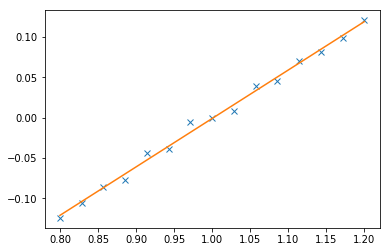

In [296]:
rotation_index = 7
print("Fractional horizontal shifts vs scale factor")
print("rotation = " + str(rotations[rotation_index] * 180 / math.pi) + " degrees")
polyfit_scale = np.polyfit(scales, fractional_horizontal_shifts[rotation_index], 1)
print("h_shift = " + str(polyfit_scale[0]) + " * scale + " + str(polyfit_scale[1]))
poly1d_scale = np.poly1d(polyfit_scale)
print(poly1d_scale)
plt.plot(
    scales, fractional_horizontal_shifts[rotation_index], 'x', 
    scales, np.poly1d(poly1d_scale)(scales))

#  0: 0.1526 x - 0.2134
#  1: 0.1905 x - 0.2443
#  2: 0.2347 x - 0.2797
#  3: 0.2991 x - 0.3355
#  4: 0.3817 x - 0.4104
#  5: 0.4875 x - 0.5055
#  6: 0.5732 x - 0.5839
#  7: 0.5997 x - 0.6007
#  8: 0.5327 x - 0.5191
#  9: 0.4832 x - 0.4607
# 10: 0.64 x - 0.6318
# 11: 0.628 x - 0.6161
# 12: 0.6112 x - 0.5943
# 13: 0.5819 x - 0.5604
# 14: 0.5649 x - 0.5355

Fractional vertical shifts vs rotation (degrees)
scale factor = 1.0
v_shift = 0.21298916803472856 * rotation (radians) + 0.0015076754385964942
v_shift = (0.6691252055921052/pi) * rotation (radians) + 0.0015076754385964942
v_shift = 0.0037173622532894733 * rotation (degrees) + 0.0015076754385964942
 
0.003717 x + 0.001508


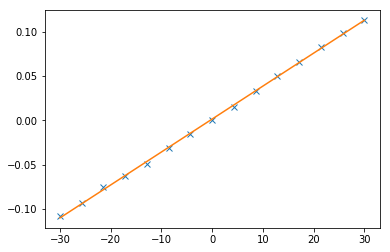

In [292]:
scale_index = 7
print("Fractional vertical shifts vs rotation (degrees)")
print("scale factor = " + str(scales[scale_index]))
polyfit_rotation = np.polyfit(rotations, fractional_vertical_shifts.T[scale_index], 1)
polyfit_rotation_degrees = np.polyfit(rotations_degrees, fractional_vertical_shifts.T[scale_index], 1)
print("v_shift = " + str(polyfit_rotation[0]) + " * rotation (radians) + " + str(polyfit_rotation[1]))
print("v_shift = (" + str(polyfit_rotation[0] * math.pi) + "/pi) * rotation (radians) + " + str(polyfit_rotation[1]))
print("v_shift = " + str(polyfit_rotation_degrees[0]) + " * rotation (degrees) + " + str(polyfit_rotation_degrees[1]))
poly1d_rotation = np.poly1d(polyfit_rotation)
poly1d_rotation_degrees = np.poly1d(polyfit_rotation_degrees)
print(poly1d_rotation_degrees)
plt.plot(
    rotations_degrees, fractional_vertical_shifts.T[scale_index], 'x', 
    rotations_degrees, np.poly1d(poly1d_rotation_degrees)(rotations_degrees))

# v_shift is roughly (2*rotation)/(3*pi)
# so rotation is roughly 1.5*pi*v_shift

#  0: 0.004098 x - 0.00122
#  1: 0.004026 x - 0.0004592
#  2: 0.003983 x + 6.853e-06
#  3: 0.003948 x + 0.0004386
#  4: 0.003885 x + 2.741e-05
#  5: 0.003857 x + 0.0006236
#  6: 0.003794 x + 0.0006168
#  7: 0.003717 x + 0.001508
#  8: 0.003645 x + 0.002337
#  9: 0.003543 x + 0.00355
# 10: 0.003409 x + 0.005181
# 11: 0.00335 x + 0.005839
# 12: 0.00333 x + 0.006325
# 13: 0.00331 x + 0.007586
# 14: 0.003337 x + 0.008141

Vertical axis: rotation, horizontal axis: scale
Left: vertical shifts, right: horizontal shifts


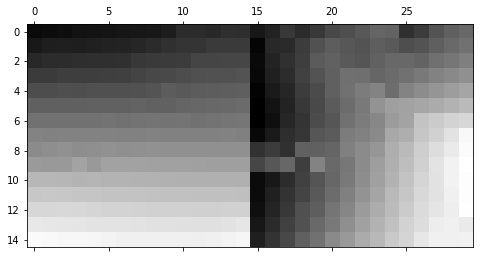

In [216]:
print("Vertical axis: rotation, horizontal axis: scale")
print("Left: vertical shifts, right: scale")
plt.matshow(np.hstack((fractional_vertical_shifts, fractional_horizontal_shifts)))

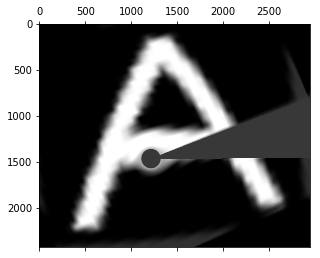

In [134]:
arr_A_scaled_and_rotated_shifted_cartesian = ipm.log_polar_to_cartesian(arr_A_scaled_and_rotated_log_polar_shifted)
plt.matshow(arr_A_scaled_and_rotated_shifted_cartesian)

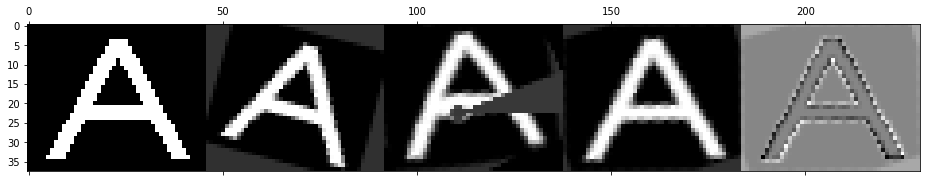

In [302]:
arr_A_scaled_and_rotated_shifted_cartesian_downsampled = skimage.transform.resize(arr_A_scaled_and_rotated_shifted_cartesian, arr_A.shape, mode='reflect', anti_aliasing=False)
scale_estimated = 1 + 5*frac_h_shift/3
rotation_estimated = 1.5 * math.pi * frac_v_shift
arr_A_scaled_and_rotated_estimated = ipm.transform_using_values(arr_A, [scale_estimated, scale_estimated, 0, rotation_estimated, 0, 0])
scale_correction = 1/scale_estimated
rotation_correction = -rotation_estimated
arr_A_correction_estimated = ipm.transform_using_values(arr_A_scaled_and_rotated, [scale_correction, scale_correction, 0, rotation_correction, 0, 0])
#plt.matshow(np.hstack((arr_A, arr_A_scaled_and_rotated, arr_A_scaled_and_rotated_shifted_cartesian_downsampled, arr_A_scaled_and_rotated_estimated, ipm.normalised_image(arr_A_scaled_and_rotated_estimated - arr_A_scaled_and_rotated))))
plt.matshow(np.hstack((arr_A, arr_A_scaled_and_rotated, arr_A_scaled_and_rotated_shifted_cartesian_downsampled, arr_A_correction_estimated, ipm.normalised_image(arr_A_correction_estimated - arr_A))))

#### Apply rigid registration to log-polar signal

In [49]:
signal_2_log_polar = ipm.log_polar_signal(signal_2)

In [50]:
shifts_2_log_polar = signal_2_log_polar.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=50)

In [52]:
signal_2_log_polar_shifted = hs.signals.Signal2D(np.empty_like(signal_2_log_polar.data))
for t in range(signal_2_log_polar.data.shape[0]):
    vfield = np.array([np.ones_like(signal_2_log_polar.data[t]) * -shifts_2_log_polar[t][0], np.ones_like(signal_2_log_polar.data[t]) * -shifts_2_log_polar[t][1]])
    signal_2_log_polar_shifted.data[t] = ipm.apply_displacement_field_sitk(vfield, signal_2_log_polar.data[t])

In [53]:
%matplotlib qt
hs.plot.plot_signals([signal_2_log_polar, signal_2_log_polar_shifted])

In [54]:
#signal_2_cartesian = ipm.cartesian_signal(signal_2_log_polar_shifted)
signal_2_cartesian = hs.signals.Signal2D(np.empty_like(signal_2.data))
for t in range(signal_2.data.shape[0]):
    signal_2_cartesian.data[t] = ipm.rotate(signal_2.data[t], shifts_2_log_polar[t][0])

In [55]:
%matplotlib qt
hs.plot.plot_signals([signal_2, signal_2_cartesian])

In [9]:
shifts_2_cartesian = signal_2_cartesian.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=50)

In [10]:
signal_2_cartesian_shifted = hs.signals.Signal2D(np.empty_like(signal_2_cartesian.data))
for t in range(signal_2_cartesian.data.shape[0]):
    vfield = np.array([np.ones_like(signal_2_cartesian.data[t]) * -shifts_2_cartesian[t][0], np.ones_like(signal_2_cartesian.data[t]) * -shifts_2_cartesian[t][1]])
    signal_2_cartesian_shifted.data[t] = ipm.apply_displacement_field_sitk(vfield, signal_2_cartesian.data[t])

In [11]:
%matplotlib qt
hs.plot.plot_signals([signal_2, signal_2_cartesian_shifted])